# This Example shows how to Semantically Segment CloudNet38 satellite images using the deep learning model Fully Convolutional Network.

### Import Modules

In [1]:
import sys
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from geotorchai.models.raster import FullyConvolutionalNetwork
from geotorchai.datasets.raster import Cloud38
from geotorchai.utility import TorchAdapter
import matplotlib.pyplot as plt

# Import Apache Sedona
from sedona.spark import *

## Import PySpark
from pyspark.sql import SparkSession


## Import distributed modules
from torch.utils.data import DistributedSampler, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from pyspark.ml.torch.distributor import TorchDistributor

import warnings
# Ignore FutureWarning warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
config = SedonaContext.builder().master(MASTER_URL).config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.4_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2').getOrCreate()

sedona = SedonaContext.create(config)
sc = sedona.sparkContext

23/08/11 19:06:53 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
23/08/11 19:06:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.4_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-566a2cdd-6443-4c60-9213-e0485f5b1273;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/kanchan/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 in central
	found org.datasyslab#geotools-wrapper;1.4.0-28.2 in central
:: resolution report :: resolve 87ms :: artifacts dl 3ms
	:: modules in use:
	org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 from central in [default]
	org.datasyslab#geotools-wrapper;1.4.0-28.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-566a2cdd-6443-4c60-9213-e0485f5b1273
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/3ms)
23/08/11 19:06:54 WARN NativeCodeLoader: Unable to load

## Get Path Prefix

In [3]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else ''

print(PATH_PREFIX)

In [4]:
## Define parameters
learning_rate = 0.0002
batch_size = 8

## make sure that PATH_TO_DATASET exists in the running directory
dataset_path = PATH_PREFIX + "data/38-Cloud_training"

### Load Data and Add Normalization Transformation

In [5]:
## load data and calculate mean and std to perform normalization transform
full_data = Cloud38(root = dataset_path)

full_loader = DataLoader(full_data, batch_size= batch_size)
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for i, sample in enumerate(full_loader):
    data_temp, _ = sample
    channels_sum += torch.mean(data_temp, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data_temp**2, dim=[0, 2, 3])
    num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

/Users/kanchan/.pyenv/versions/3.11.0/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
## Define the transform operation
sat_transform = transforms.Normalize(mean, std)
## Load data with desired transformation and additional handcrafted features enabled
full_data = Cloud38(root = dataset_path, transform = sat_transform)

### Display Spectral Bands of an Image

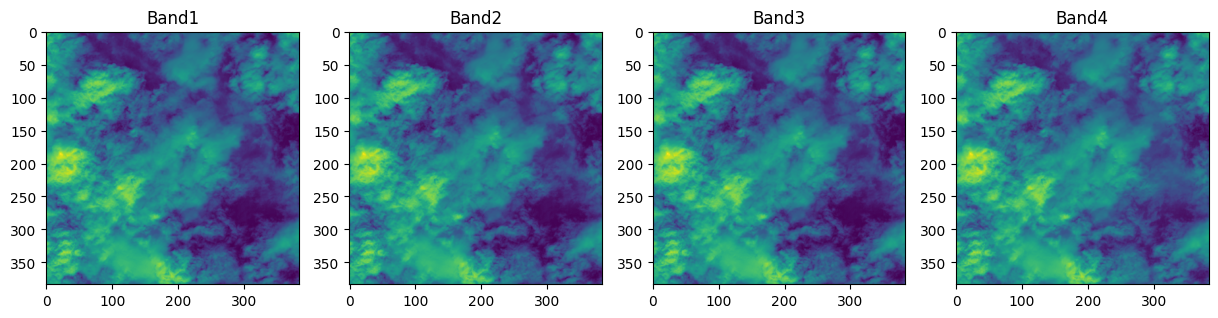

In [ ]:
## Display various bands from an input image
input_data, label = full_data[9]
TorchAdapter.visualize_all_bands(input_data, 4, 1, 4)

## Display the Segmentation of the Above Image

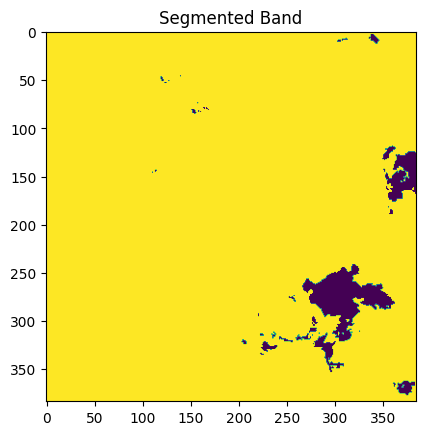

In [8]:
input_data, label = full_data[9]
TorchAdapter.visualize_single_band_image(label, "Segmented Band")

### Method to Return Model

In [9]:
def get_model():
    ## Define Model
    model = FullyConvolutionalNetwork(4, 2)
    return model

### Train Model
Accuracy will not be high sinvce training is performed on a small dataset for only 5 epochs

In [10]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    for i, sample in enumerate(train_loader):
        inputs, labels = sample
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(True):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
    return loss.item()

In [11]:
def train_model(model, loader, device):
    ## Define hyper-parameters
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for e in range(epoch_nums):
        epoch_loss = train_one_epoch(model, loader, optimizer, loss_fn, device)
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, epoch_loss))

In [12]:
def train_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = get_model().to(device)
    model_ddp = DDP(model)
    sampler = DistributedSampler(full_data)
    loader = DataLoader(full_data, batch_size=batch_size, sampler=sampler)

    train_model(model_ddp, loader, device)

## Start Distributed Training

In [ ]:
print("Starting training")
distributor = TorchDistributor(num_processes=2, local_mode=True, use_gpu=False)
distributor.run(train_distributed, False)